<a href="https://colab.research.google.com/github/umair-hassan2/paligemma-3b-finetuning/blob/master/valorant_paligemma_dataset_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers bitsandbytes peft
# Downgrading for issue: https://github.com/mahmoodlab/HEST/issues/110
!pip install datasets==2.16.0
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 7.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully

In [2]:
import torch
import cv2
import re

from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from PIL import ImageDraw
from IPython.display import display

from transformers import Trainer
from transformers import TrainingArguments
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from huggingface_hub import snapshot_download

In [3]:
ds = load_dataset("keremberke/valorant-object-detection", "full")
# Dataset classes
classes = ['dropped spike', 'enemy', 'planted spike', 'teammate']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1983 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/988 [00:00<?, ? examples/s]

In [4]:
print(ds)
print("SAMPLE TRAINING EXAMPLE")
print(ds['train'][0])

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6927
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1983
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 988
    })
})
SAMPLE TRAINING EXAMPLE
{'image_id': 3947, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x416 at 0x7B27E403A270>, 'width': 416, 'height': 416, 'objects': {'id': [4083], 'area': [3718], 'bbox': [[147.0, 201.0, 33.5, 111.0]], 'category': [1]}}


In [5]:
def visualize(example):
  image = example['image']
  category_idx = example['objects']['category'][0]
  display(image)
  category = classes[category_idx - 1]
  print(f"Object Category: {category}")

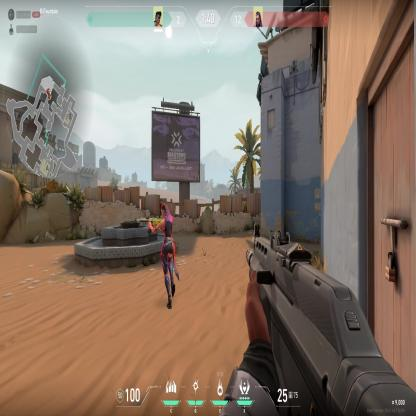

Object Category: dropped spike


In [6]:
visualize(ds['train'][0])

In [7]:
def coco_to_xyxy(coordinates):
  x, y, width, height = coordinates
  x1, y1 = x, y
  x2 = x1 + width
  y2 = y1 + height
  return [x1, y1, x2, y2]

In [8]:
def formatted_value(cord_point, d):
  # Normalize value between [0, 1024]
  cord_point= int(round((cord_point * 1024) / d))
  return f"<loc{cord_point:04}>"

def paligemma_format(coordinates, categories, img_width, img_height):
  norm_config = [img_width, img_height]
  formatted_strs = []
  for cord, category in zip(coordinates, categories):
    xyxy_cord = coco_to_xyxy(cord)
    label = classes[category - 1]
    p_points = []
    for index, edge_point in enumerate(xyxy_cord):
      p_point = formatted_value(edge_point, norm_config[index % 2])
      p_points.append(p_point)
    paligemma_bbox = "".join(p_points)
    formatted_strs.append(f"{paligemma_bbox} {label}")

  response = " ; ".join(formatted_strs)
  return response

In [9]:
def paligemma_decoded_format(encoded_bbox):
  """
  This method decodes Paligemma specific format <locXXXX><locXXXX><locXXXX><locXXXX> [CLASS]; <locXXXX><locXXXX><locXXXX><locXXXX> [CLASS] ; ...
  into XYXY format [x1, y1, x2, y2] where each values represnts corner points of bounding box

  Decodes string like "<loc0005><loc0234><loc0450><loc0678> cat"
  into
  [
    {
      'bbox': [5, 234, 450, 678],
      'label': cat
    }
  ]
  """
  pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s+([^;]+)"
  matches = re.findall(pattern, encoded_bbox)
  decoded_strs = []
  for c_match in matches:
    if len(c_match) < 5:
      raise ValueError("Not Enough <locXXXX> tokens found")
    coords = list(map(lambda x: int(x)/1024, c_match[:4]))
    label = c_match[4].strip()
    decoded_strs.append({
        'label': label,
        'bbox': coords
    })

  return decoded_strs

In [10]:
# Create and return paligemma label for a sample
def create_paligemma_label(example):
  categories = example['objects']['category']
  bboxes = example['objects']['bbox']

  paligemma_label = paligemma_format(bboxes, categories, example['width'], example['height'])
  return {'paligemma_label': paligemma_label}

In [11]:
# Add extra paligemma column to dataset
for key in ds.keys():
  ds[key] = ds[key].map(lambda example: create_paligemma_label(example))

Map:   0%|          | 0/6927 [00:00<?, ? examples/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/988 [00:00<?, ? examples/s]

In [12]:
# hugging face login
from huggingface_hub import notebook_login
notebook_login()
!git config --global credential.helper store

In [14]:
print("PUSHING DATASET TO HUGGING FACE HUB")
repo_id = "umairhassan02/paligemma-valorant-object-detection-transformed"
ds.push_to_hub(
    repo_id= repo_id,
    commit_message="Updated paligemma format encoded dataset for valorant object detection"
)

PUSHING DATASET TO HUGGING FACE HUB


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/6927 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/70 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/988 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/umairhassan02/paligemma-valorant-object-detection-transformed/commit/fae5a00ac64fbb9d8c5cbcbf428f2289dd8dd7c5', commit_message='Updated paligemma format encoded dataset for valorant object detection', commit_description='', oid='fae5a00ac64fbb9d8c5cbcbf428f2289dd8dd7c5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/umairhassan02/paligemma-valorant-object-detection-transformed', endpoint='https://huggingface.co', repo_type='dataset', repo_id='umairhassan02/paligemma-valorant-object-detection-transformed'), pr_revision=None, pr_num=None)